# Transformer Chatbot

In [1]:
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

     |████████████████████████████████| 2.3MB 14.9MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


##Prepare Dataset - Facebook Json


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import json

file=open('/content/drive/MyDrive/Colab Notebooks/data/dataset.json');
data = json.load(file)

In [10]:
def clean_text(text):
    text = text.lower().strip()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", " not", text)
    return text

In [11]:
def preprocess_sentence(sentence):
  sentence = clean_text(sentence)
  sentence = sentence.replace('_comma_', ',')
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = re.sub(r"  ","",sentence)
  sentence = sentence.strip()
  return sentence

In [12]:
MAX_SENTENCE_LENGTH = 60


In [13]:
def load_conversations():
    count = 0
    inputs, outputs = [], []
    for convo in data:
        for i in range(len(convo)-1):
            count = count + 1
            if len(convo[i])<=MAX_SENTENCE_LENGTH and len(convo[i+1])<=MAX_SENTENCE_LENGTH:
                inputs.append(preprocess_sentence(convo[i]))
                outputs.append(preprocess_sentence(convo[i+1]))
    print(count)
    return inputs, outputs

questions, answers = load_conversations()


58881


In [14]:
len(questions)
len(answers)

18023

In [15]:
print('Question: ' + questions[69])
print('Answer: ' + answers[69])

Question: new orleans it was great
Answer: i live in texas so that it really close to me


##Prepare Dataset - CounselChat CSV

In [16]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/20200325_counsel_chat.csv')

In [17]:
##load convo from df and concenatate

def load_conversations_from_csv():
    inputs, outputs = [], []

    for index, row in df.iterrows():
        ip = preprocess_sentence(row['questionTitle'])
        op = preprocess_sentence(row['answerText'].replace('\n', ' '))

        if len(ip.split())>MAX_SENTENCE_LENGTH:
            continue
        
        outputs.append(op.split('.')[0].strip())
        inputs.append(ip)
        
    return inputs, outputs

questions2, answers2 = load_conversations_from_csv()

In [18]:
print(len(questions2))
print(len(answers2))

2127
2127


In [19]:
print('Question: ' + questions2[40])
print('Answer: ' + answers2[40])

Question: do i have too many issues for counseling ?
Answer: no , it is natural for us to have a number of issues going on if we do not address the concerns we have in our lives


In [20]:
questions = questions + questions2
answers = answers + answers2

In [21]:
len(questions)
len(answers)

20150

In [22]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

In [23]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[27])))

Tokenized sample question: [23, 4, 19, 145, 5480, 2297, 3]


In [24]:
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check tokenized sentence max length
    if len(sentence1) <= MAX_SENTENCE_LENGTH and len(sentence2) <= MAX_SENTENCE_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_SENTENCE_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_SENTENCE_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [25]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8515
Number of samples: 20096


In [26]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 60), dec_inputs: (None, 59)}, {outputs: (None, 59)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Attention



In [28]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking



In [30]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [31]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [32]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [33]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding


In [34]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

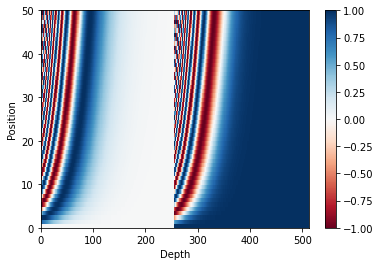

In [35]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout


In [36]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

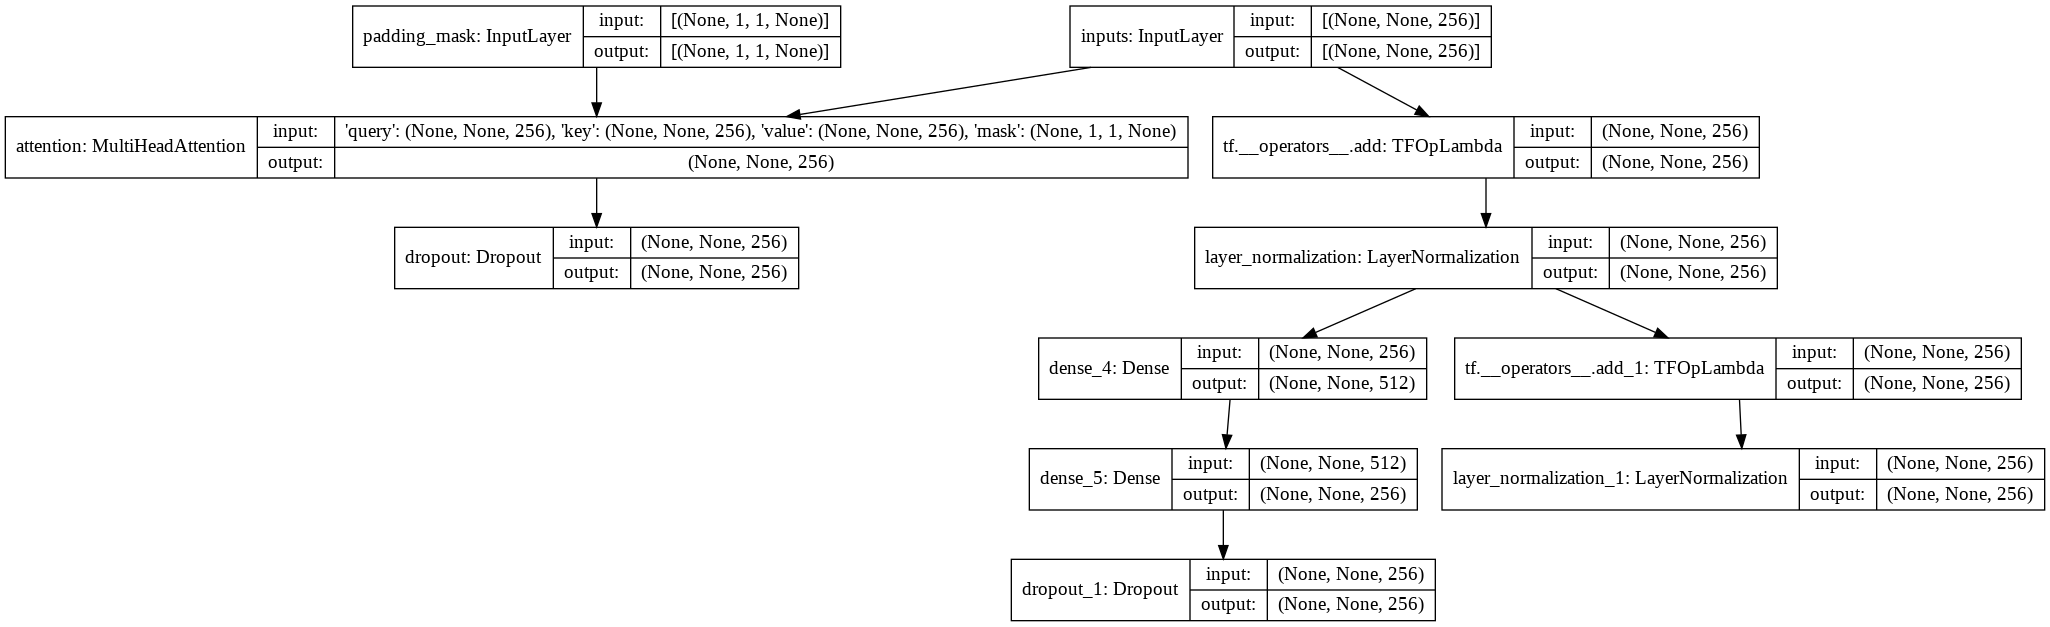

In [37]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers



In [38]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

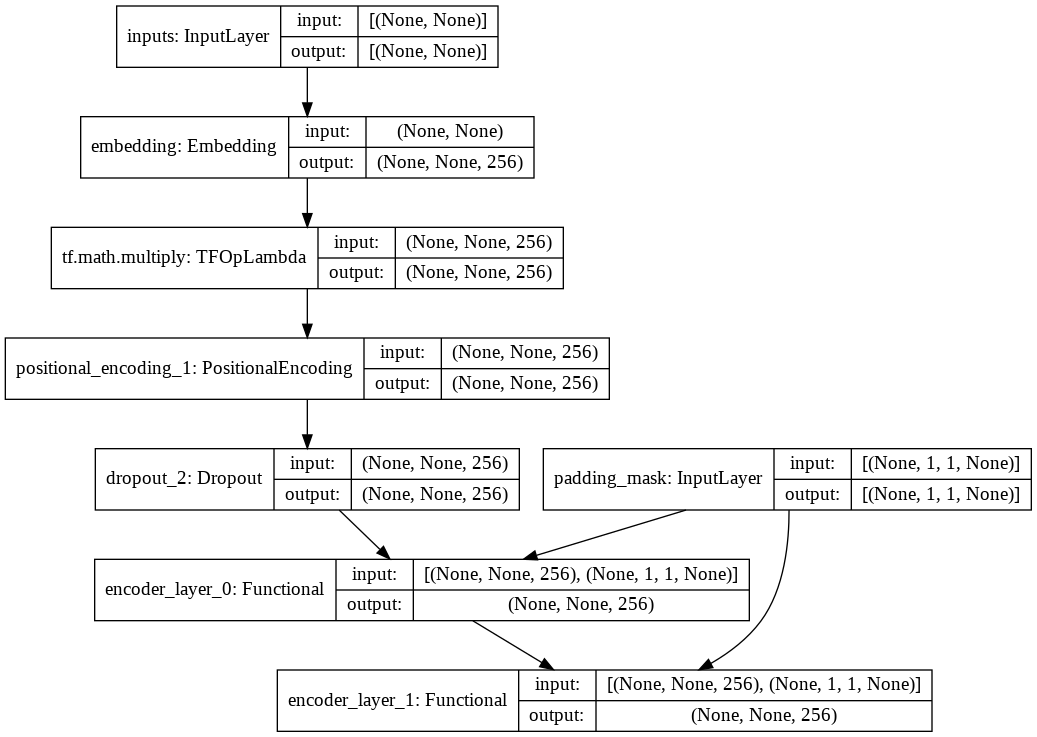

In [39]:
sample_encoder = encoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout


In [40]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

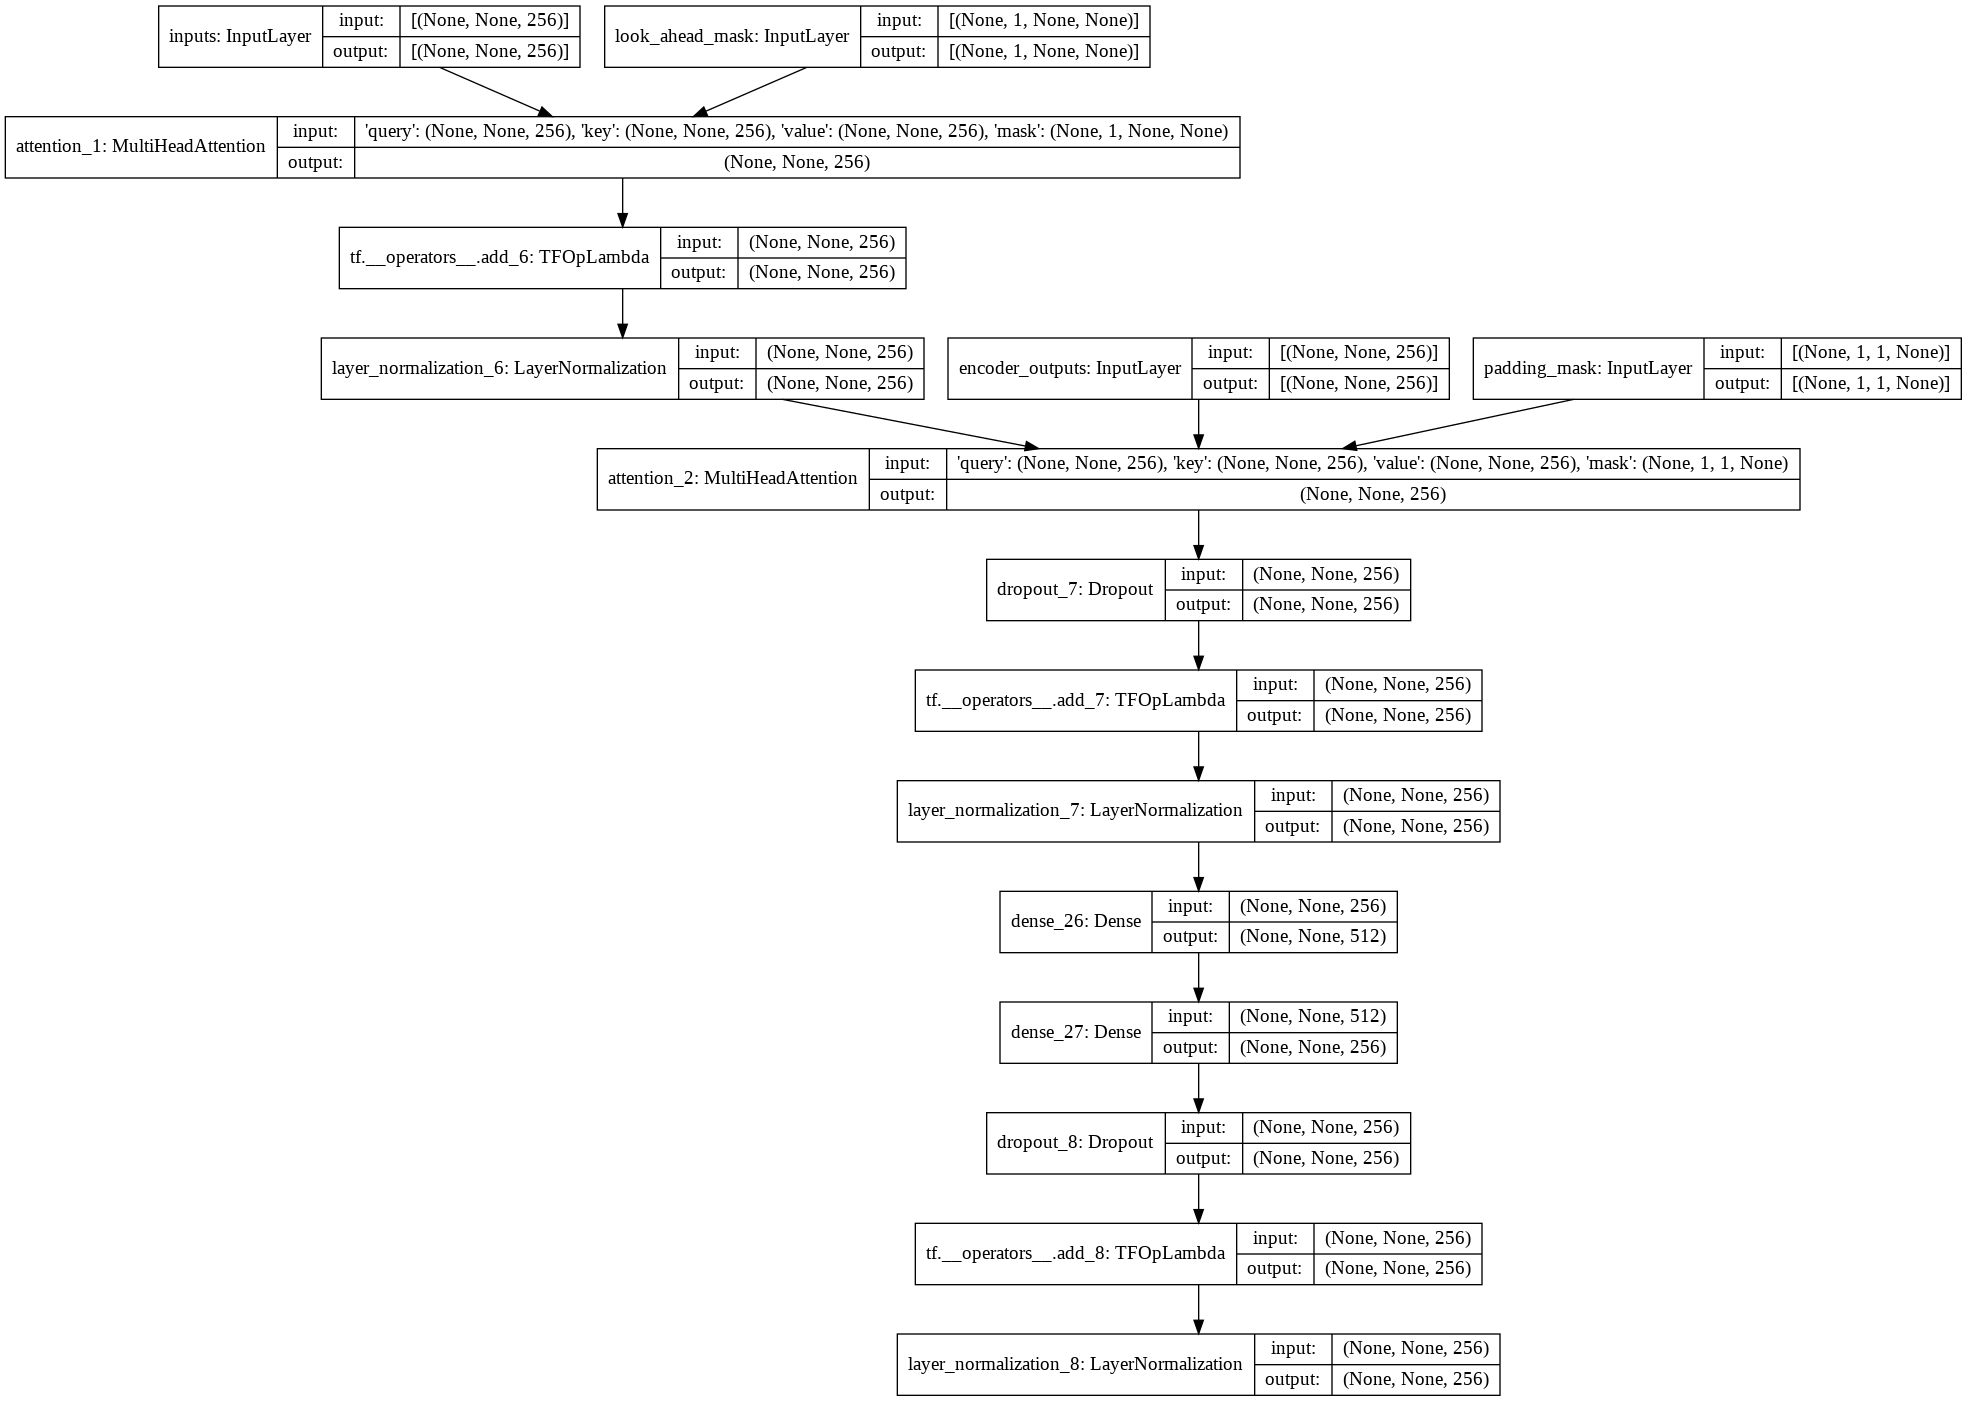

In [41]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers



In [42]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

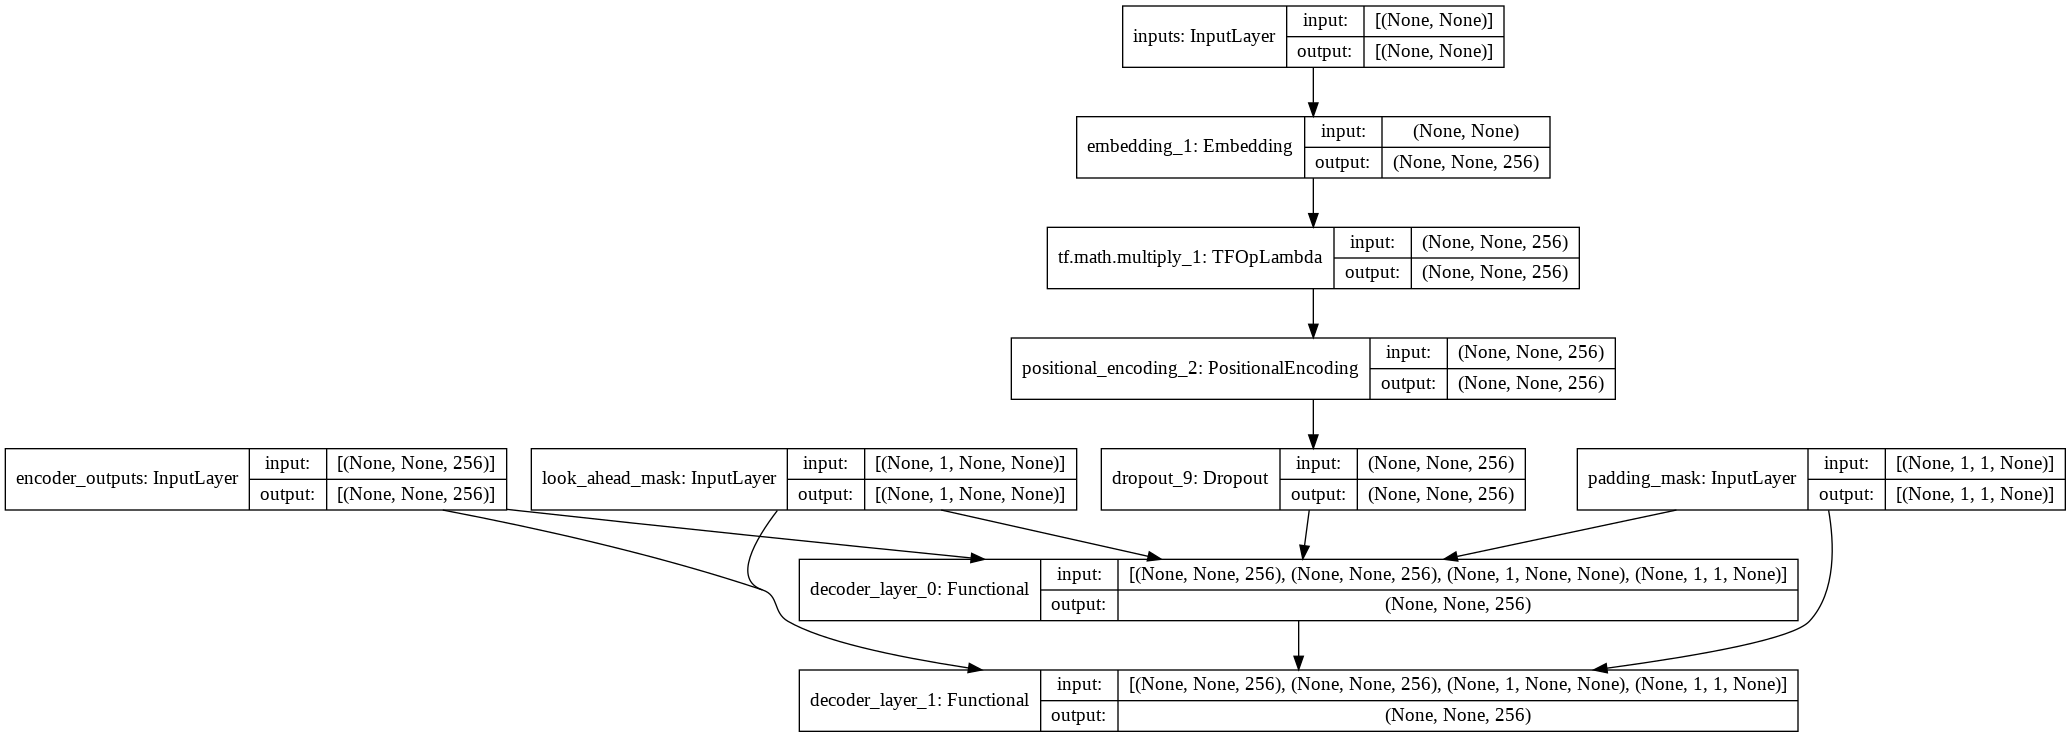

In [43]:
sample_decoder = decoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [44]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

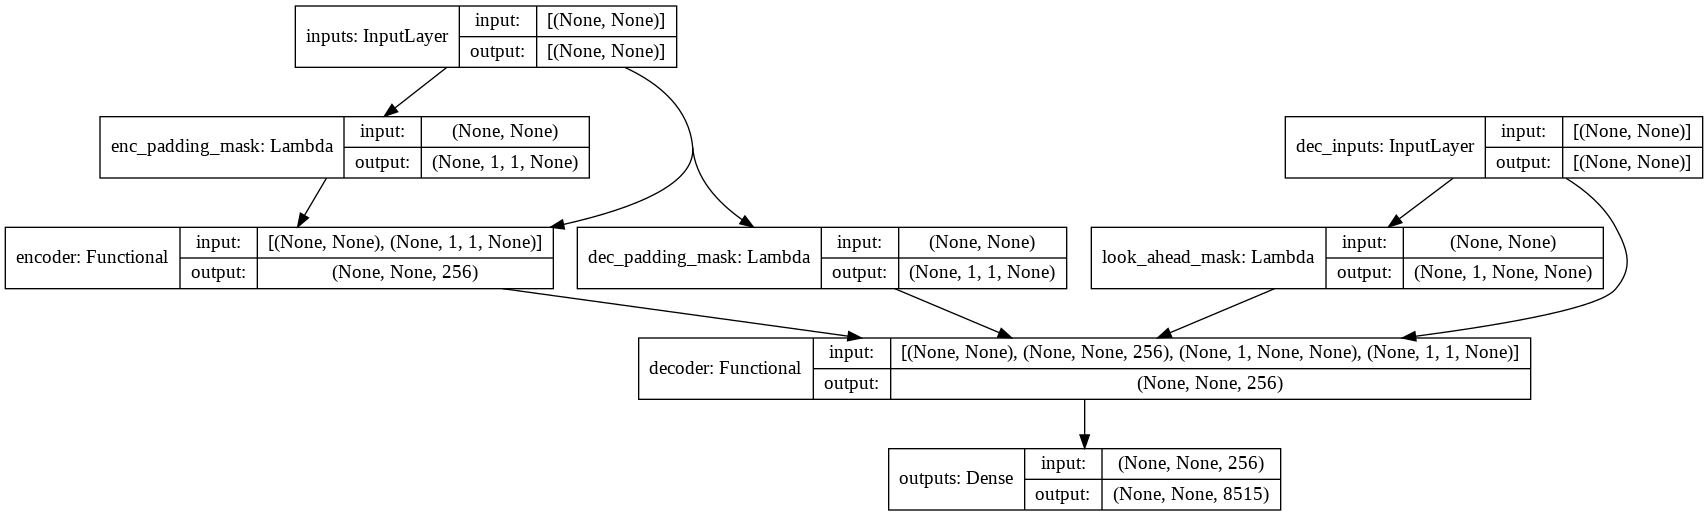

In [45]:
sample_transformer = transformer(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model



In [46]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1


In [ ]:
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [47]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [48]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

**Number of training steps per epoch:**

total_number_of_training_examples / batch_size.

20081/64 = *314*

**Total number of training steps:** 

number_of_epochs x Number of training steps per epoch.

12 x 314 = 3140

Text(0.5, 0, 'Train Step')

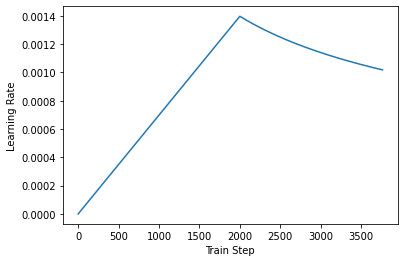

In [49]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(3768, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [50]:
# perplexity function

def perplexity(real, pred):
    """
    This function returns the perplexity for model's predictions on a batch 
    of data in comparison with the real outputs at a timestep.
    Arguments:
        real: real output, a Tensorflow tensor with a shape 
              of: (batch_size, max_seq_length)
        pred: model's predictions at a certain timestep, a Tensorflow tensor 
              with a shape of: (batch_size, max_seq_length)
    Returns:
        A Tensorflow tensor with the perplexity.
    """
    real = tf.reshape(real, shape=(-1, MAX_SENTENCE_LENGTH - 1))
    loss = loss_function(real, pred)
    
    return tf.cast(tf.pow(math.e, loss), dtype=tf.keras.backend.floatx())

In [51]:
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_SENTENCE_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy, perplexity], run_eagerly=True)

### Fit model


In [ ]:
EPOCHS = 12

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/12
314/314 [==============================] - 77s 245ms/step - loss: 1.2976 - accuracy: 0.0200 - perplexity: 3.7778
Epoch 2/12
314/314 [==============================] - 76s 242ms/step - loss: 0.8720 - accuracy: 0.0456 - perplexity: 2.4013
Epoch 3/12
314/314 [==============================] - 76s 243ms/step - loss: 0.7610 - accuracy: 0.0532 - perplexity: 2.1454
Epoch 4/12
314/314 [==============================] - 76s 243ms/step - loss: 0.7093 - accuracy: 0.0573 - perplexity: 2.0372
Epoch 5/12
314/314 [==============================] - 76s 242ms/step - loss: 0.6685 - accuracy: 0.0608 - perplexity: 1.9549
Epoch 6/12
314/314 [==============================] - 76s 242ms/step - loss: 0.6329 - accuracy: 0.0640 - perplexity: 1.8866
Epoch 7/12
314/314 [==============================] - 76s 242ms/step - loss: 0.5959 - accuracy: 0.0677 - perplexity: 1.8179
Epoch 8/12
314/314 [==============================] - 76s 242ms/step - loss: 0.5441 - accuracy: 0.0734 - perplexity: 1.7254
Epoch 9/

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/data/bot_4')

In [53]:
#1 is json+csv over 10 epochs lr 3k
#2 is json+csv over 15 epochs lr 3k
#3 is json+csv over 12 epochs again. because you messed up saving it.
#4 is json+csv over 12 epochs lr 2k

'''
# Create a new model instance
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# Restore the weights
model.load_weights('/content/drive/MyDrive/Colab Notebooks/data/bot_4')
'''


## Evaluate and predict


In [ ]:
import language_check

tool = language_check.LanguageTool('en-US')

In [54]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_SENTENCE_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])
  
  matches = tool.check(predicted_sentence)
  predicted_sentence = language_check.correct(predicted_sentence, matches)
  
  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

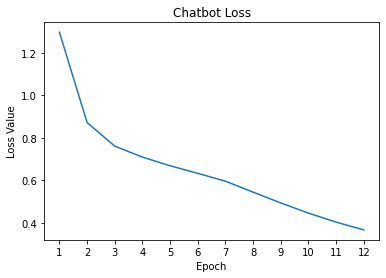

In [ ]:
# loss graph

epochs = list(range(1,EPOCHS+1))
plt.plot(epochs, history.history['loss'], label='loss')
plt.xticks(epochs)
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Chatbot Loss')
plt.show()

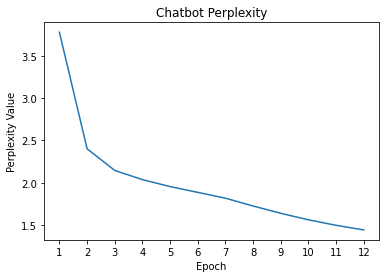

In [ ]:
# perplexity graph

epochs = list(range(1,EPOCHS+1))
plt.plot(epochs, history.history['perplexity'], label='perplexity')
plt.xticks(epochs)
plt.ylabel('Perplexity Value')
plt.xlabel('Epoch')
plt.title('Chatbot Perplexity')
plt.show()

Let's test our model!

In [55]:
output = predict("I feel incredibly stressed out.")

Input: I feel incredibly stressed out.
Output: why do you say that ?


In [56]:
output = predict("I want to kill myself now.")

Input: I want to kill myself now.
Output: i am sorry to hear that . what happened ?


In [57]:
output = predict("My husband died. I can't stop crying.")

Input: My husband died. I can't stop crying.
Output: i am sorry to hear that . how long have you been married ?


In [ ]:
output = predict("My pet died. I can't stop crying now.")

Input: My pet died. I can't stop crying now.
Output: i am sorry to hear that . was it sudden ?


In [ ]:
output = predict('Is it okay to feel sad all the time?')

Input: Is it okay to feel sad all the time?
Output: i am so sorry to hear that . it is a very normal to feel better now .


In [ ]:
output = predict("I feel incredibly stressed out.")

Input: I feel incredibly stressed out.
Output: why is that ?


In [ ]:
output = predict("My pet died. I can't stop crying now.")

Input: My pet died. I can't stop crying now.
Output: i am sorry to hear that . i hope you are okay .


In [ ]:
output = predict("I want to kill myself.")

Input: I want to kill myself.
Output: i do not know what you mean . why do you need to do that ?


In [ ]:
for _ in range(3):
  sentence = input('User: ')
  prediction = evaluate(sentence)
  predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

  matches = tool.check(predicted_sentence)
  predicted_sentence = language_check.correct(predicted_sentence, matches)
  
  print("Bot: ", predicted_sentence)

User: i feel stressed out
Bot:  i am sorry to hear you are feeling that way
User: i have a lot of work to finish
Bot:  i bet you are going to have a good time !
User: i doubt that
Bot:  i am sorry to hear that . that is holding you back ?


In [ ]:
for _ in range(3):
  sentence = input('User: ')
  prediction = evaluate(sentence)
  predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

  matches = tool.check(predicted_sentence)
  predicted_sentence = language_check.correct(predicted_sentence, matches)

  print("Bot: ", predicted_sentence)

User: I feel sad
Bot:  i am sorry to hear of your suffering
User: i have a lot of work to finish
Bot:  i bet you are going to have a good time !
User: i do not think so
Bot:  i am sure you will figure it out


In [ ]:
# feed the model with its previous output

sentence = 'I had a huge fight with my friend today. I hate him.'
for _ in range(4):
  sentence = predict(sentence)
  print('')

Input: I had a huge fight with my friend today. I hate him.
Output: oh that is bad . what happened ?

Input: oh that is bad . what happened ?
Output: i had to work

Input: i had to work
Output: what did you do ?

Input: what did you do ?
Output: i did not tell them because i was very upset about it .

